In [191]:
from parcels import (
    FieldSet,
    JITParticle,
    ScipyParticle,
    ParticleSet,
    AdvectionRK4,
    AdvectionRK4_3D,
    StatusCode,
)
import parcels

import datetime as dt
from datetime import datetime, timedelta

import dask
from dask.distributed import Client

import numpy as np

from pathlib import Path
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean

import xarray as xr
from glob import glob
import cartopy
import cartopy.crs as ccrs
from cartopy.crs import Geodetic, Stereographic, PlateCarree
from cartopy.feature import LAND, COASTLINE
import xoak
from time import time
import warnings

warnings.simplefilter("ignore")


In [199]:
working_directory = Path("/gxfs_work/geomar/smomw597/2025_Fucus/Fucus_location_shp")
location_file = Path(working_directory, "REDLIST_SIS_Macrophytes.shp")
# location_file = "zip://gxfs_work/geomar/smomw597/2025_Fucus/REDLIST_SIS_Macrophytes.zip!data"
fucus_locations = gpd.read_file(location_file)

In [200]:
# fucus_locations[fucus_locations.where(fucus_locations !=0)]#.plot()
location_columns = np.delete(fucus_locations.columns.values, [0, 10, 25, 26])
fucus_locations = fucus_locations.drop(labels=location_columns, axis=1)

In [201]:
fucus_locations = fucus_locations.drop(fucus_locations[fucus_locations.F_vesiculo ==0].index).to_crs(crs=ccrs.Geodetic())

In [202]:
# Set the basic mapping parameters
suptitle_size = 20
title_size = 16
mapsize = (16, 8)
extent = (9, 29, 52, 64)
lonmid = np.mean(extent[:2])
latmid = np.mean(extent[2:])
map_projection = ccrs.Stereographic(
    central_longitude=lonmid, central_latitude=latmid,
    )
def basemap(ax):
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.add_feature(LAND)
    ax.add_feature(COASTLINE)
    ax.gridlines(draw_labels=["left", "bottom"], y_inline=False,)
    return ax

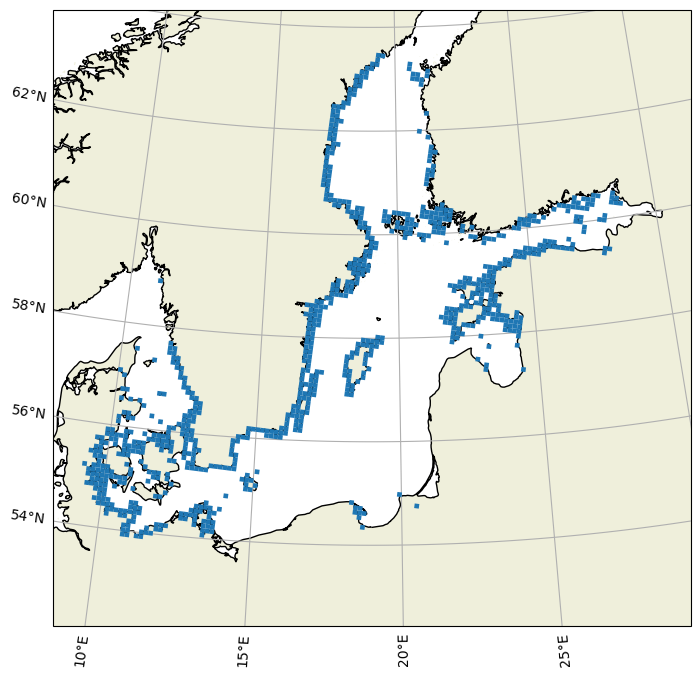

In [203]:
fig = plt.figure(figsize=mapsize)
ax_map = fig.add_subplot(projection=map_projection)
basemap(ax_map)
fucus_locations.to_crs(crs=map_projection).plot(ax = ax_map, zorder=5, )
map_extent = ax_map.get_extent(crs=map_projection)
plt.show()

In [209]:
ocean_50m = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m')

for i, poly in enumerate(ocean_50m.intersecting_geometries(map_extent)):
    if i == 0:
        polygon = list([poly])
    else:
        polygon.append(poly)
ocean_poly = gpd.GeoDataFrame({'geometry':polygon}, crs=Geodetic()).clip(fucus_locations)
ocean_poly
fucus_locations_ocean = fucus_locations.clip(ocean_poly).sort_index()
fucus_locations_ocean['Clipped_Area'] = fucus_locations_ocean.area*1e6
fucus_locations_ocean

,CELLCODE,F_vesiculo,Shape_Area,geometry,Clipped_Area
49699,10kmE488N418,2,4.084090e+08,"POLYGON ((20.16755 60.44855, 20.34688 60.43555...",16280.225739
49700,10kmE489N414,2,3.993617e+08,"POLYGON ((20.23662 60.08001, 20.41398 60.06694...",16053.826258
49701,10kmE489N418,2,4.080819e+08,"POLYGON ((20.34688 60.43555, 20.52608 60.42233...",16273.725649
49702,10kmE492N414,2,3.983968e+08,"POLYGON ((20.7683 60.04015, 20.94527 60.02642,...",16080.096883
49703,10kmE492N418,2,4.070696e+08,"POLYGON ((20.88407 60.39521, 21.06286 60.38132...",16253.595145
...,...,...,...,...,...
51213,10kmE513N397,3,3.582345e+08,"POLYGON ((23.8422 58.21194, 24.00905 58.19448,...",15250.940358
51214,10kmE515N399,3,3.610691e+08,"POLYGON ((24.4134 58.33453, 24.37774 58.24674,...",12816.613470
51215,10kmE515N420,2,4.020849e+08,"POLYGON ((25.0252 60.16995, 25.114 60.18636, 2...",15145.132234
51216,10kmE516N397,3,3.571695e+08,"POLYGON ((24.34228 58.15895, 24.46981 58.1451,...",12032.759812


In [214]:
fucus_locations.to_crs(crs=Geodetic()).area

49699    0.016280
49700    0.016099
49701    0.016274
49702    0.016080
49703    0.016254
           ...   
51213    0.015251
51214    0.015311
51215    0.016154
51216    0.015228
51217    0.016188
Length: 872, dtype: float64

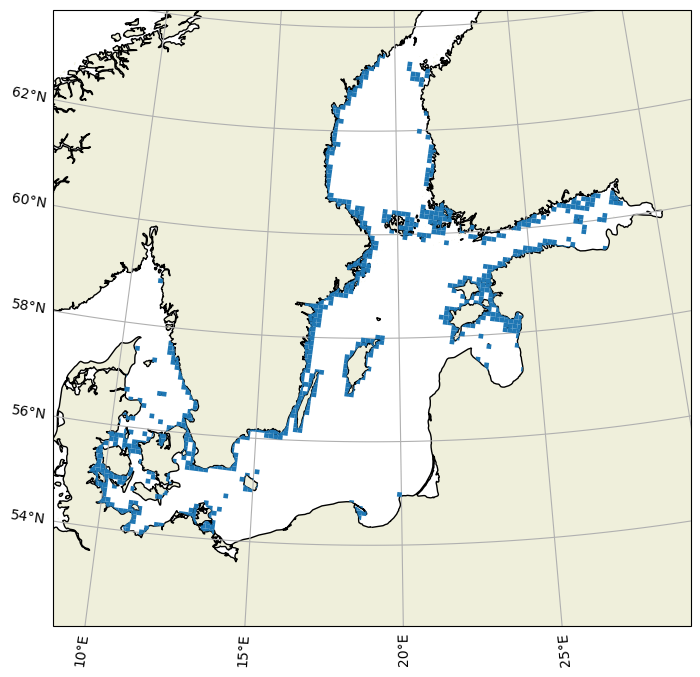

In [217]:
fig = plt.figure(figsize=mapsize)
ax_map = fig.add_subplot(projection=map_projection)
basemap(ax_map)
fucus_locations_ocean.to_crs(crs=map_projection).plot(ax = ax_map, zorder=5, )
map_extent = ax_map.get_extent(crs=map_projection)
plt.show()

In [218]:
output_path = Path("/gxfs_work/geomar/smomw597/2025_Fucus/output/SamplePoints")
fucus_locations = Path(output_path,"fucus_locations.shp")
fucus_locations_ocean.to_file(fucus_locations)